In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_SingleStep_v10 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-14 17:23:39.105631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:23:39.106122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:23:39.162499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:23:39.162870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:23:39.163223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

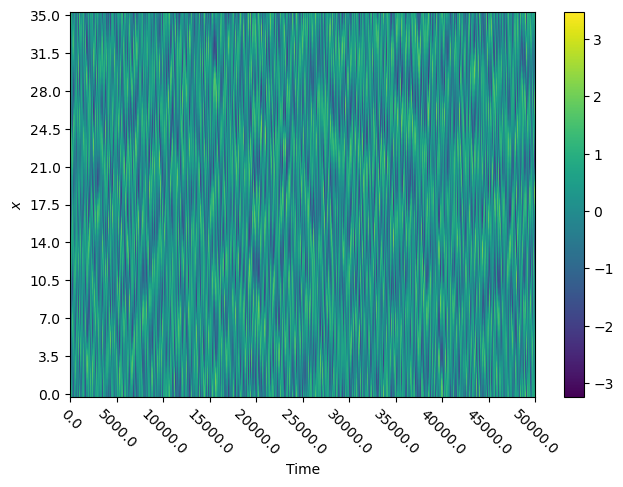

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

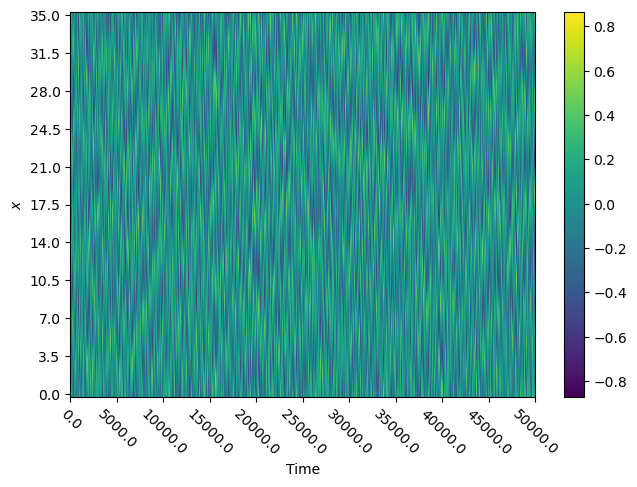

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

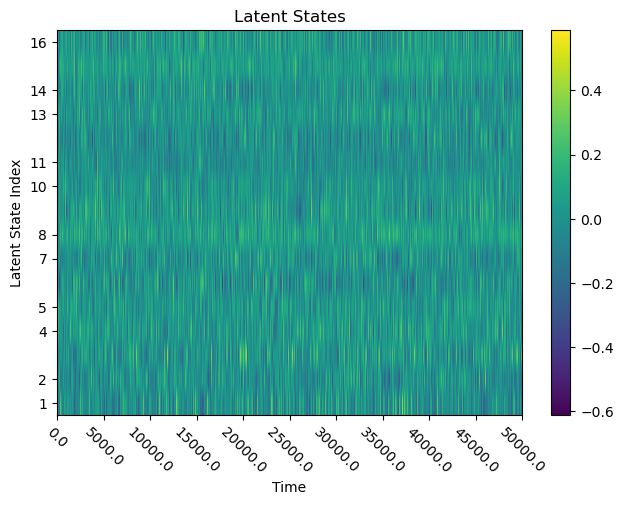

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.1
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]

    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [500]*3
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=None, # corresponding to RK4
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=None, # corresponding to RK4
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.006613247394561768


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [34]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0360 - mse: 0.0344 - NMSE: 0.3101 - tot_time: 0h 0m 18.7s

Epoch 1: val_NMSE improved from inf to 0.10814, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 19s 2s/step - loss: 0.0360 - mse: 0.0344 - NMSE: 0.3101 - val_loss: 0.0136 - val_mse: 0.0120 - val_NMSE: 0.1081
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0103 - mse: 0.0088 - NMSE: 0.0792 - tot_time: 0h 0m 34.1s

Epoch 2: val_NMSE improved from 0.10814 to 0.06662, saving model to /home

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0011 - NMSE: 0.0095 - tot_time: 0h 7m 45.3s

Epoch 30: val_NMSE improved from 0.01013 to 0.00994, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0017 - mse: 0.0011 - NMSE: 0.0095 - val_loss: 0.0018 - val_mse: 0.0011 - val_NMSE: 0.0099
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0010 - NMSE: 0.0094 - tot_time: 0h 8m 0.7s

Epoch 31: val_NMSE improved from 0.00994 to 0.00975, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s

Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 8.2694e-04 - NMSE: 0.0074 - tot_time: 0h 11m 33.3s

Epoch 45: val_NMSE improved from 0.00783 to 0.00772, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0014 - mse: 8.2694e-04 - NMSE: 0.0074 - val_loss: 0.0014 - val_mse: 8.5782e-04 - val_NMSE: 0.0077
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 8.1521e-04 - NMSE: 0.0073 - tot_time: 0h 11m 48.6s

Epoch 46: val_NMSE improved from 0.00772 to 0.00761, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0012 - mse: 6.9088e-04 - NMSE: 0.0062 - val_loss: 0.0012 - val_mse: 7.0702e-04 - val_NMSE: 0.0064
Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 6.8244e-04 - NMSE: 0.0061 - tot_time: 0h 15m 21.5s

Epoch 60: val_NMSE improved from 0.00636 to 0.00629, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0012 - mse: 6.8244e-04 - NMSE: 0.0061 - val_loss: 0.0012 - val_mse: 6.9840e-04 - val_NMSE: 0.0063
Epoch 61/1000
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 6.7473e-04 - NMSE: 0.0061 - tot_time: 0h 15m 36.5s

Epoch 61: val_N

Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 5.9103e-04 - NMSE: 0.0053 - tot_time: 0h 18m 53.7s

Epoch 74: val_NMSE improved from 0.00544 to 0.00539, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 0.0011 - mse: 5.9103e-04 - NMSE: 0.0053 - val_loss: 0.0011 - val_mse: 5.9853e-04 - val_NMSE: 0.0054
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 5.8516e-04 - NMSE: 0.0053 - tot_time: 0h 19m 9.6s

Epoch 75: val_NMSE improved from 0.00539 to 0.00533, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [===================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0010 - mse: 5.2091e-04 - NMSE: 0.0047 - val_loss: 0.0010 - val_mse: 5.2230e-04 - val_NMSE: 0.0047
Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 5.1657e-04 - NMSE: 0.0046   - tot_time: 0h 22m 42.0s

Epoch 89: val_NMSE improved from 0.00470 to 0.00467, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0010 - mse: 5.1657e-04 - NMSE: 0.0046 - val_loss: 0.0010 - val_mse: 5.1826e-04 - val_NMSE: 0.0047
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 9.9477e-04 - mse: 5.1261e-04 - NMSE: 0.0046 - tot_time: 0h 22m 57.1s

Epoch 90:

Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 9.1941e-04 - mse: 4.6372e-04 - NMSE: 0.0042 - tot_time: 0h 26m 15.7s

Epoch 103: val_NMSE improved from 0.00418 to 0.00415, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 9.1941e-04 - mse: 4.6372e-04 - NMSE: 0.0042 - val_loss: 9.1594e-04 - val_mse: 4.6138e-04 - val_NMSE: 0.0042
Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 9.1419e-04 - mse: 4.6054e-04 - NMSE: 0.0041 - tot_time: 0h 26m 31.2s

Epoch 104: val_NMSE improved from 0.00415 to 0.00412, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8

8/8 [==============================] - ETA: 0s - loss: 7.8452e-04 - mse: 3.8472e-04 - NMSE: 0.0035 - tot_time: 0h 33m 32.0s

Epoch 131: val_NMSE improved from 0.00341 to 0.00338, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 7.8452e-04 - mse: 3.8472e-04 - NMSE: 0.0035 - val_loss: 7.7460e-04 - val_mse: 3.7588e-04 - val_NMSE: 0.0034
Epoch 132/1000
8/8 [==============================] - ETA: 0s - loss: 7.8022e-04 - mse: 3.8236e-04 - NMSE: 0.0034 - tot_time: 0h 33m 47.6s

Epoch 132: val_NMSE improved from 0.00338 to 0.00336, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [=============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.8087e-04 - mse: 3.3333e-04 - NMSE: 0.0030 - val_loss: 6.6143e-04 - val_mse: 3.1489e-04 - val_NMSE: 0.0028
Epoch 160/1000
8/8 [==============================] - ETA: 0s - loss: 6.7630e-04 - mse: 3.3054e-04 - NMSE: 0.0030 - tot_time: 0h 41m 7.6s

Epoch 160: val_NMSE improved from 0.00283 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 6.7630e-04 - mse: 3.3054e-04 - NMSE: 0.0030 - val_loss: 6.5901e-04 - val_mse: 3.1424e-04 - val_NMSE: 0.0028
Epoch 161/1000
8/8 [==============================] - ETA: 0s - loss: 6.7325e-04 - mse: 3.2926e-04 - NMSE: 0.0030 - tot_time: 0h 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 5.8724e-04 - mse: 2.8846e-04 - NMSE: 0.0026 - val_loss: 5.6478e-04 - val_mse: 2.6689e-04 - val_NMSE: 0.0024
Epoch 189/1000
8/8 [==============================] - ETA: 0s - loss: 5.8305e-04 - mse: 2.8584e-04 - NMSE: 0.0026 - tot_time: 0h 48m 41.1s

Epoch 189: val_NMSE improved from 0.00240 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 5.8305e-04 - mse: 2.8584e-04 - NMSE: 0.0026 - val_loss: 5.6137e-04 - val_mse: 2.6505e-04 - val_NMSE: 0.0024
Epoch 190/1000
8/8 [==============================] - ETA: 0s - loss: 5.7875e-04 - mse: 2.8311e-04 - NMSE: 0.0025 - tot_time: 0h

Epoch 204/1000
8/8 [==============================] - ETA: 0s - loss: 5.4058e-04 - mse: 2.6604e-04 - NMSE: 0.0024 - tot_time: 0h 52m 32.2s

Epoch 204: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.4058e-04 - mse: 2.6604e-04 - NMSE: 0.0024 - val_loss: 5.2026e-04 - val_mse: 2.4654e-04 - val_NMSE: 0.0022
Epoch 205/1000
8/8 [==============================] - ETA: 0s - loss: 5.3828e-04 - mse: 2.6519e-04 - NMSE: 0.0024 - tot_time: 0h 52m 47.5s

Epoch 205: val_NMSE improved from 0.00222 to 0.00221, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 5.3828e-04 - mse: 2.6519e-04 - NMSE: 0.0024 - v

Epoch 219/1000
8/8 [==============================] - ETA: 0s - loss: 5.0041e-04 - mse: 2.4673e-04 - NMSE: 0.0022 - tot_time: 0h 56m 24.8s

Epoch 219: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.0041e-04 - mse: 2.4673e-04 - NMSE: 0.0022 - val_loss: 4.7992e-04 - val_mse: 2.2699e-04 - val_NMSE: 0.0020
Epoch 220/1000
8/8 [==============================] - ETA: 0s - loss: 4.9897e-04 - mse: 2.4662e-04 - NMSE: 0.0022 - tot_time: 0h 56m 40.0s

Epoch 220: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.9897e-04 - mse: 2.4662e-04 - NMSE: 0.0022 - val_loss: 4.7822e-04 - val_mse: 2.2661e-04 - val_NMSE: 0.0020
Epoch 221/1000
8/8 [======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.5850e-04 - mse: 2.2397e-04 - NMSE: 0.0020 - val_loss: 4.4297e-04 - val_mse: 2.0912e-04 - val_NMSE: 0.0019
Epoch 235/1000
8/8 [==============================] - ETA: 0s - loss: 4.5851e-04 - mse: 2.2519e-04 - NMSE: 0.0020 - tot_time: 1h 0m 31.4s

Epoch 235: val_NMSE improved from 0.00185 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 4.5851e-04 - mse: 2.2519e-04 - NMSE: 0.0020 - val_loss: 4.3801e-04 - val_mse: 2.0536e-04 - val_NMSE: 0.0018
Epoch 236/1000
8/8 [==============================] - ETA: 0s - loss: 4.5764e-04 - mse: 2.2553e-04 - NMSE: 0.0020 - tot_time: 1h 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.1812e-04 - mse: 2.0108e-04 - NMSE: 0.0018 - val_loss: 3.9253e-04 - val_mse: 1.7612e-04 - val_NMSE: 0.0016
Epoch 250/1000
8/8 [==============================] - ETA: 0s - loss: 4.1735e-04 - mse: 2.0143e-04 - NMSE: 0.0018 - tot_time: 1h 4m 25.7s

Epoch 250: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.1735e-04 - mse: 2.0143e-04 - NMSE: 0.0018 - val_loss: 3.9234e-04 - val_mse: 1.7704e-04 - val_NMSE: 0.0016
Epoch 251/1000
8/8 [==============================] - ETA: 0s - loss: 4.1760e-04 - mse: 2.0279e-04 - NMSE: 0.0018 - tot_time: 1h 4m 40.9s

Epoch 251: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/D

8/8 [==============================] - ETA: 0s - loss: 3.9203e-04 - mse: 1.9200e-04 - NMSE: 0.0017 - tot_time: 1h 8m 17.7s

Epoch 265: val_NMSE did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.9203e-04 - mse: 1.9200e-04 - NMSE: 0.0017 - val_loss: 3.6605e-04 - val_mse: 1.6659e-04 - val_NMSE: 0.0015
Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 3.9001e-04 - mse: 1.9099e-04 - NMSE: 0.0017 - tot_time: 1h 8m 33.0s

Epoch 266: val_NMSE improved from 0.00149 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 3.9001e-04 - mse: 1.9099e-04 - NMSE: 0.0017 - val_loss: 3.6235e-

Epoch 281/1000
8/8 [==============================] - ETA: 0s - loss: 3.6117e-04 - mse: 1.7647e-04 - NMSE: 0.0016 - tot_time: 1h 12m 22.6s

Epoch 281: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.6117e-04 - mse: 1.7647e-04 - NMSE: 0.0016 - val_loss: 3.3505e-04 - val_mse: 1.5086e-04 - val_NMSE: 0.0014
Epoch 282/1000
8/8 [==============================] - ETA: 0s - loss: 3.5890e-04 - mse: 1.7511e-04 - NMSE: 0.0016 - tot_time: 1h 12m 37.8s

Epoch 282: val_NMSE improved from 0.00135 to 0.00133, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 3.5890e-04 - mse: 1.7511e-04 - NMSE: 0.0016 - v

8/8 [==============================] - ETA: 0s - loss: 3.1166e-04 - mse: 1.5233e-04 - NMSE: 0.0014 - tot_time: 1h 20m 20.2s

Epoch 312: val_NMSE improved from 0.00111 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 3.1166e-04 - mse: 1.5233e-04 - NMSE: 0.0014 - val_loss: 2.8111e-04 - val_mse: 1.2219e-04 - val_NMSE: 0.0011
Epoch 313/1000
8/8 [==============================] - ETA: 0s - loss: 3.0673e-04 - mse: 1.4813e-04 - NMSE: 0.0013 - tot_time: 1h 20m 35.8s

Epoch 313: val_NMSE improved from 0.00110 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [=============

Epoch 328/1000
8/8 [==============================] - ETA: 0s - loss: 2.9072e-04 - mse: 1.4237e-04 - NMSE: 0.0013 - tot_time: 1h 24m 27.0s

Epoch 328: val_NMSE did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9072e-04 - mse: 1.4237e-04 - NMSE: 0.0013 - val_loss: 2.6614e-04 - val_mse: 1.1815e-04 - val_NMSE: 0.0011
Epoch 329/1000
8/8 [==============================] - ETA: 0s - loss: 2.9036e-04 - mse: 1.4266e-04 - NMSE: 0.0013 - tot_time: 1h 24m 42.1s

Epoch 329: val_NMSE did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9036e-04 - mse: 1.4266e-04 - NMSE: 0.0013 - val_loss: 2.6420e-04 - val_mse: 1.1685e-04 - val_NMSE: 0.0011
Epoch 330/1000
8/8 [======================

Epoch 8/1000
8/8 [==============================] - ETA: 0s - loss: 2.5043e-04 - mse: 1.1026e-04 - NMSE: 9.9248e-04 - tot_time: 1h 32m 11.1s

Epoch 8: val_NMSE improved from 0.00077 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.5043e-04 - mse: 1.1026e-04 - NMSE: 9.9248e-04 - val_loss: 2.2517e-04 - val_mse: 8.5024e-05 - val_NMSE: 7.6534e-04
Epoch 9/1000
8/8 [==============================] - ETA: 0s - loss: 2.5036e-04 - mse: 1.1024e-04 - NMSE: 9.9236e-04 - tot_time: 1h 32m 26.4s

Epoch 9: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5036e-04 - mse: 1.1024e-04 - NMSE: 9.

8/8 [==============================] - ETA: 0s - loss: 2.4645e-04 - mse: 1.0806e-04 - NMSE: 9.7271e-04 - tot_time: 1h 39m 21.1s

Epoch 36: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4645e-04 - mse: 1.0806e-04 - NMSE: 9.7271e-04 - val_loss: 2.2127e-04 - val_mse: 8.2912e-05 - val_NMSE: 7.4633e-04
Epoch 37/1000
8/8 [==============================] - ETA: 0s - loss: 2.4630e-04 - mse: 1.0798e-04 - NMSE: 9.7196e-04 - tot_time: 1h 39m 36.3s

Epoch 37: val_NMSE improved from 0.00075 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4630e-04 - mse: 1.0798e-04 - NMSE: 9.7196e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4451e-04 - mse: 1.0706e-04 - NMSE: 9.6368e-04 - val_loss: 2.1926e-04 - val_mse: 8.1856e-05 - val_NMSE: 7.3682e-04
Epoch 51/1000
8/8 [==============================] - ETA: 0s - loss: 2.4441e-04 - mse: 1.0704e-04 - NMSE: 9.6348e-04 - tot_time: 1h 43m 13.4s

Epoch 51: val_NMSE improved from 0.00074 to 0.00074, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4441e-04 - mse: 1.0704e-04 - NMSE: 9.6348e-04 - val_loss: 2.1906e-04 - val_mse: 8.1724e-05 - val_NMSE: 7.3564e-04
Epoch 52/1000
8/8 [==============================] - ETA: 0s - loss: 2.4413e-04 - mse: 1.0682e-04 - NMSE: 9.61

Epoch 65/1000
8/8 [==============================] - ETA: 0s - loss: 2.4238e-04 - mse: 1.0598e-04 - NMSE: 9.5401e-04 - tot_time: 1h 46m 52.7s

Epoch 65: val_NMSE improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.4238e-04 - mse: 1.0598e-04 - NMSE: 9.5401e-04 - val_loss: 2.1702e-04 - val_mse: 8.0666e-05 - val_NMSE: 7.2611e-04
Epoch 66/1000
8/8 [==============================] - ETA: 0s - loss: 2.4237e-04 - mse: 1.0604e-04 - NMSE: 9.5455e-04 - tot_time: 1h 47m 9.2s

Epoch 66: val_NMSE improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesChe

Epoch 79/1000
8/8 [==============================] - ETA: 0s - loss: 2.4030e-04 - mse: 1.0493e-04 - NMSE: 9.4449e-04 - tot_time: 1h 50m 38.5s

Epoch 79: val_NMSE improved from 0.00072 to 0.00072, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.4030e-04 - mse: 1.0493e-04 - NMSE: 9.4449e-04 - val_loss: 2.1501e-04 - val_mse: 7.9668e-05 - val_NMSE: 7.1713e-04
Epoch 80/1000
8/8 [==============================] - ETA: 0s - loss: 2.4009e-04 - mse: 1.0478e-04 - NMSE: 9.4318e-04 - tot_time: 1h 50m 54.2s

Epoch 80: val_NMSE improved from 0.00072 to 0.00072, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.3635e-04 - mse: 1.0310e-04 - NMSE: 9.2801e-04 - val_loss: 2.1090e-04 - val_mse: 7.7696e-05 - val_NMSE: 6.9938e-04
Epoch 108/1000
8/8 [==============================] - ETA: 0s - loss: 2.3628e-04 - mse: 1.0311e-04 - NMSE: 9.2816e-04 - tot_time: 1h 58m 15.4s

Epoch 108: val_NMSE improved from 0.00070 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.3628e-04 - mse: 1.0311e-04 - NMSE: 9.2816e-04 - val_loss: 2.1072e-04 - val_mse: 7.7587e-05 - val_NMSE: 6.9839e-04
Epoch 109/1000
8/8 [==============================] - ETA: 0s - loss: 2.3598e-04 - mse: 1.0289e-04 - NMSE: 9

Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 2.3432e-04 - mse: 1.0226e-04 - NMSE: 9.2050e-04 - tot_time: 2h 1m 54.8s

Epoch 122: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.3432e-04 - mse: 1.0226e-04 - NMSE: 9.2050e-04 - val_loss: 2.0886e-04 - val_mse: 7.6847e-05 - val_NMSE: 6.9173e-04
Epoch 123/1000
8/8 [==============================] - ETA: 0s - loss: 2.3416e-04 - mse: 1.0218e-04 - NMSE: 9.1972e-04 - tot_time: 2h 2m 10.4s

Epoch 123: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.3252e-04 - mse: 1.0159e-04 - NMSE: 9.1450e-04 - val_loss: 2.0694e-04 - val_mse: 7.6063e-05 - val_NMSE: 6.8468e-04
Epoch 137/1000
8/8 [==============================] - ETA: 0s - loss: 2.3239e-04 - mse: 1.0155e-04 - NMSE: 9.1408e-04 - tot_time: 2h 5m 51.3s

Epoch 137: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.3239e-04 - mse: 1.0155e-04 - NMSE: 9.1408e-04 - val_loss: 2.0677e-04 - val_mse: 7.5972e-05 - val_NMSE: 6.8386e-04
Epoch 138/1000
8/8 [==============================] - ETA: 0s - loss: 2.3204e-04 - mse: 1.0128e-04 - NMSE: 9.

Epoch 151/1000
8/8 [==============================] - ETA: 0s - loss: 2.3048e-04 - mse: 1.0080e-04 - NMSE: 9.0736e-04 - tot_time: 2h 9m 34.0s

Epoch 151: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.3048e-04 - mse: 1.0080e-04 - NMSE: 9.0736e-04 - val_loss: 2.0502e-04 - val_mse: 7.5385e-05 - val_NMSE: 6.7858e-04
Epoch 152/1000
8/8 [==============================] - ETA: 0s - loss: 2.3028e-04 - mse: 1.0068e-04 - NMSE: 9.0628e-04 - tot_time: 2h 9m 49.9s

Epoch 152: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.2837e-04 - mse: 9.9877e-05 - NMSE: 8.9903e-04 - val_loss: 2.0302e-04 - val_mse: 7.4575e-05 - val_NMSE: 6.7128e-04
Epoch 166/1000
8/8 [==============================] - ETA: 0s - loss: 2.2822e-04 - mse: 9.9805e-05 - NMSE: 8.9838e-04 - tot_time: 2h 13m 27.5s

Epoch 166: val_NMSE did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2822e-04 - mse: 9.9805e-05 - NMSE: 8.9838e-04 - val_loss: 2.0295e-04 - val_mse: 7.4589e-05 - val_NMSE: 6.7140e-04
Epoch 167/1000
8/8 [==============================] - ETA: 0s - loss: 2.2799e-04 - mse: 9.9661e-05 - NMSE: 8.9709e-04 - tot_time: 2h 13m 42.7s

Epoch 167: val_NMSE improved from 0.00067 to 0.00067, saving model 

Epoch 180/1000
8/8 [==============================] - ETA: 0s - loss: 2.2620e-04 - mse: 9.8988e-05 - NMSE: 8.9104e-04 - tot_time: 2h 17m 2.7s

Epoch 180: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2620e-04 - mse: 9.8988e-05 - NMSE: 8.9104e-04 - val_loss: 2.0091e-04 - val_mse: 7.3744e-05 - val_NMSE: 6.6380e-04
Epoch 181/1000
8/8 [==============================] - ETA: 0s - loss: 2.2599e-04 - mse: 9.8869e-05 - NMSE: 8.8996e-04 - tot_time: 2h 17m 17.8s

Epoch 181: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistorie

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2396e-04 - mse: 9.7955e-05 - NMSE: 8.8174e-04 - val_loss: 1.9889e-04 - val_mse: 7.2934e-05 - val_NMSE: 6.5651e-04
Epoch 195/1000
8/8 [==============================] - ETA: 0s - loss: 2.2399e-04 - mse: 9.8076e-05 - NMSE: 8.8283e-04 - tot_time: 2h 20m 49.6s

Epoch 195: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2399e-04 - mse: 9.8076e-05 - NMSE: 8.8283e-04 - val_loss: 1.9881e-04 - val_mse: 7.2949e-05 - val_NMSE: 6.5664e-04
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 2.2380e-04 - mse: 9.7972e-05 - NMSE: 8.8189e-04 - tot_time: 2h 21m 4.5s

Epoch 196: val_NMSE did not improve from 0.00066
 - saving loss hist

Epoch 209/1000
8/8 [==============================] - ETA: 0s - loss: 2.2183e-04 - mse: 9.7140e-05 - NMSE: 8.7440e-04 - tot_time: 2h 24m 21.7s

Epoch 209: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2183e-04 - mse: 9.7140e-05 - NMSE: 8.7440e-04 - val_loss: 1.9671e-04 - val_mse: 7.2065e-05 - val_NMSE: 6.4869e-04
Epoch 210/1000
8/8 [==============================] - ETA: 0s - loss: 2.2152e-04 - mse: 9.6918e-05 - NMSE: 8.7240e-04 - tot_time: 2h 24m 36.8s

Epoch 210: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2152e-04 - mse: 9.6918e-05 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1948e-04 - mse: 9.6014e-05 - NMSE: 8.6426e-04 - val_loss: 1.9464e-04 - val_mse: 7.1225e-05 - val_NMSE: 6.4113e-04
Epoch 224/1000
8/8 [==============================] - ETA: 0s - loss: 2.1943e-04 - mse: 9.6054e-05 - NMSE: 8.6462e-04 - tot_time: 2h 28m 8.4s

Epoch 224: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1943e-04 - mse: 9.6054e-05 - NMSE: 8.6462e-04 - val_loss: 1.9458e-04 - val_mse: 7.1247e-05 - val_NMSE: 6.4132e-04
Epoch 225/1000
8/8 [==============================] - ETA: 0s - loss: 2.1912e-04 - mse: 9.5830e-05 - NMSE: 8.6261e-04 - tot_time: 2h 28m 23.1s

Epoch 225: val_NMSE did not improve from 0.00064
 - saving loss hist

Epoch 253/1000
8/8 [==============================] - ETA: 0s - loss: 2.1456e-04 - mse: 9.3735e-05 - NMSE: 8.4375e-04 - tot_time: 2h 35m 26.0s

Epoch 253: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1456e-04 - mse: 9.3735e-05 - NMSE: 8.4375e-04 - val_loss: 1.9002e-04 - val_mse: 6.9238e-05 - val_NMSE: 6.2324e-04
Epoch 254/1000
8/8 [==============================] - ETA: 0s - loss: 2.1451e-04 - mse: 9.3771e-05 - NMSE: 8.4407e-04 - tot_time: 2h 35m 41.2s

Epoch 254: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistori

Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss: 2.1230e-04 - mse: 9.2791e-05 - NMSE: 8.3525e-04 - tot_time: 2h 39m 15.7s

Epoch 268: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1230e-04 - mse: 9.2791e-05 - NMSE: 8.3525e-04 - val_loss: 1.8753e-04 - val_mse: 6.8073e-05 - val_NMSE: 6.1276e-04
Epoch 269/1000
8/8 [==============================] - ETA: 0s - loss: 2.1204e-04 - mse: 9.2621e-05 - NMSE: 8.3372e-04 - tot_time: 2h 39m 30.9s

Epoch 269: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0980e-04 - mse: 9.1517e-05 - NMSE: 8.2379e-04 - val_loss: 1.8486e-04 - val_mse: 6.6622e-05 - val_NMSE: 5.9969e-04
Epoch 283/1000
8/8 [==============================] - ETA: 0s - loss: 2.0969e-04 - mse: 9.1492e-05 - NMSE: 8.2356e-04 - tot_time: 2h 43m 2.6s

Epoch 283: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0969e-04 - mse: 9.1492e-05 - NMSE: 8.2356e-04 - val_loss: 1.8472e-04 - val_mse: 6.6573e-05 - val_NMSE: 5.9925e-04
Epoch 284/1000
8/8 [==============================] - ETA: 0s - loss: 2.0931e-04 - mse: 9.1195e-05 - NMSE: 8.

Epoch 297/1000
8/8 [==============================] - ETA: 0s - loss: 2.0730e-04 - mse: 9.0318e-05 - NMSE: 8.1299e-04 - tot_time: 2h 46m 36.2s

Epoch 297: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0730e-04 - mse: 9.0318e-05 - NMSE: 8.1299e-04 - val_loss: 1.8232e-04 - val_mse: 6.5391e-05 - val_NMSE: 5.8861e-04
Epoch 298/1000
8/8 [==============================] - ETA: 0s - loss: 2.0696e-04 - mse: 9.0071e-05 - NMSE: 8.1077e-04 - tot_time: 2h 46m 51.4s

Epoch 298: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistori

Epoch 312/1000
8/8 [==============================] - ETA: 0s - loss: 2.0488e-04 - mse: 8.9201e-05 - NMSE: 8.0293e-04 - tot_time: 2h 50m 22.8s

Epoch 312: val_NMSE improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0488e-04 - mse: 8.9201e-05 - NMSE: 8.0293e-04 - val_loss: 1.7982e-04 - val_mse: 6.4186e-05 - val_NMSE: 5.7777e-04
Epoch 313/1000
8/8 [==============================] - ETA: 0s - loss: 2.0466e-04 - mse: 8.9062e-05 - NMSE: 8.0169e-04 - tot_time: 2h 50m 38.0s

Epoch 313: val_NMSE did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0466e-04 - mse: 8.9062e-05 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.0258e-04 - mse: 8.8102e-05 - NMSE: 7.9304e-04 - val_loss: 1.7739e-04 - val_mse: 6.2960e-05 - val_NMSE: 5.6673e-04
Epoch 327/1000
8/8 [==============================] - ETA: 0s - loss: 2.0225e-04 - mse: 8.7855e-05 - NMSE: 7.9082e-04 - tot_time: 2h 54m 10.2s

Epoch 327: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0225e-04 - mse: 8.7855e-05 - NMSE: 7.9082e-04 - val_loss: 1.7724e-04 - val_mse: 6.2889e-05 - val_NMSE: 5.6609e-04
Epoch 328/1000
8/8 [==============================] - ETA: 0s - loss: 2.0205e-04 - mse: 8.7739e-05 - NMSE: 7

Epoch 341/1000
8/8 [==============================] - ETA: 0s - loss: 1.9993e-04 - mse: 8.6716e-05 - NMSE: 7.8057e-04 - tot_time: 2h 57m 42.8s

Epoch 341: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9993e-04 - mse: 8.6716e-05 - NMSE: 7.8057e-04 - val_loss: 1.7474e-04 - val_mse: 6.1578e-05 - val_NMSE: 5.5429e-04
Epoch 342/1000
8/8 [==============================] - ETA: 0s - loss: 1.9985e-04 - mse: 8.6725e-05 - NMSE: 7.8065e-04 - tot_time: 2h 57m 58.4s

Epoch 342: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9985e-04 - mse: 8.6725e-05 - 

8/8 [==============================] - ETA: 0s - loss: 1.9767e-04 - mse: 8.5721e-05 - NMSE: 7.7161e-04 - tot_time: 3h 1m 27.5s

Epoch 356: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9767e-04 - mse: 8.5721e-05 - NMSE: 7.7161e-04 - val_loss: 1.7232e-04 - val_mse: 6.0418e-05 - val_NMSE: 5.4384e-04
Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 1.9754e-04 - mse: 8.5666e-05 - NMSE: 7.7112e-04 - tot_time: 3h 1m 42.9s

Epoch 357: val_NMSE did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9754e-04 - mse: 8.5666e-05 - NMSE: 7.7112e-04 

Epoch 371/1000
8/8 [==============================] - ETA: 0s - loss: 1.9523e-04 - mse: 8.4519e-05 - NMSE: 7.6079e-04 - tot_time: 3h 5m 12.3s

Epoch 371: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9523e-04 - mse: 8.4519e-05 - NMSE: 7.6079e-04 - val_loss: 1.6999e-04 - val_mse: 5.9322e-05 - val_NMSE: 5.3398e-04
Epoch 372/1000
8/8 [==============================] - ETA: 0s - loss: 1.9509e-04 - mse: 8.4459e-05 - NMSE: 7.6025e-04 - tot_time: 3h 5m 27.5s

Epoch 372: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistories

Epoch 386/1000
8/8 [==============================] - ETA: 0s - loss: 1.9297e-04 - mse: 8.3477e-05 - NMSE: 7.5142e-04 - tot_time: 3h 8m 58.6s

Epoch 386: val_NMSE did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9297e-04 - mse: 8.3477e-05 - NMSE: 7.5142e-04 - val_loss: 1.6757e-04 - val_mse: 5.8119e-05 - val_NMSE: 5.2316e-04
Epoch 387/1000
8/8 [==============================] - ETA: 0s - loss: 1.9284e-04 - mse: 8.3428e-05 - NMSE: 7.5098e-04 - tot_time: 3h 9m 13.4s

Epoch 387: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9284e-04 - mse: 8.3428e-05 - NM

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9070e-04 - mse: 8.2327e-05 - NMSE: 7.4106e-04 - val_loss: 1.6520e-04 - val_mse: 5.6870e-05 - val_NMSE: 5.1191e-04
Epoch 401/1000
8/8 [==============================] - ETA: 0s - loss: 1.9067e-04 - mse: 8.2378e-05 - NMSE: 7.4152e-04 - tot_time: 3h 12m 44.4s

Epoch 401: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9067e-04 - mse: 8.2378e-05 - NMSE: 7.4152e-04 - val_loss: 1.6517e-04 - val_mse: 5.6918e-05 - val_NMSE: 5.1235e-04
Epoch 402/1000
8/8 [==============================] - ETA: 0s - loss: 1.9048e-04 - mse: 8.2265e-05 - NMSE: 7.4050e-04 - tot_time: 3h 12m 59.2s

Epoch 402: val_NMSE improved from 0.00051 to 0.00051, saving model 

Epoch 415/1000
8/8 [==============================] - ETA: 0s - loss: 1.8872e-04 - mse: 8.1526e-05 - NMSE: 7.3385e-04 - tot_time: 3h 16m 15.9s

Epoch 415: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8872e-04 - mse: 8.1526e-05 - NMSE: 7.3385e-04 - val_loss: 1.6302e-04 - val_mse: 5.5870e-05 - val_NMSE: 5.0291e-04
Epoch 416/1000
8/8 [==============================] - ETA: 0s - loss: 1.8853e-04 - mse: 8.1407e-05 - NMSE: 7.3278e-04 - tot_time: 3h 16m 30.7s

Epoch 416: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8853e-04 - mse: 8.1407e-05 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8649e-04 - mse: 8.0368e-05 - NMSE: 7.2343e-04 - val_loss: 1.6098e-04 - val_mse: 5.4898e-05 - val_NMSE: 4.9416e-04
Epoch 430/1000
8/8 [==============================] - ETA: 0s - loss: 1.8638e-04 - mse: 8.0328e-05 - NMSE: 7.2307e-04 - tot_time: 3h 20m 3.0s

Epoch 430: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8638e-04 - mse: 8.0328e-05 - NMSE: 7.2307e-04 - val_loss: 1.6085e-04 - val_mse: 5.4843e-05 - val_NMSE: 4.9367e-04
Epoch 431/1000
8/8 [==============================] - ETA: 0s - loss: 1.8632e-04 - mse: 8.0352e-05 - NMSE: 7.

8/8 [==============================] - ETA: 0s - loss: 1.8251e-04 - mse: 7.8602e-05 - NMSE: 7.0753e-04 - tot_time: 3h 27m 19.6s

Epoch 459: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8251e-04 - mse: 7.8602e-05 - NMSE: 7.0753e-04 - val_loss: 1.5683e-04 - val_mse: 5.2960e-05 - val_NMSE: 4.7671e-04
Epoch 460/1000
8/8 [==============================] - ETA: 0s - loss: 1.8259e-04 - mse: 7.8751e-05 - NMSE: 7.0887e-04 - tot_time: 3h 27m 34.3s

Epoch 460: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8259e-04 - mse: 7.8751e-05 - NMSE: 7.0887e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8086e-04 - mse: 7.7998e-05 - NMSE: 7.0209e-04 - val_loss: 1.5492e-04 - val_mse: 5.2099e-05 - val_NMSE: 4.6896e-04
Epoch 475/1000
8/8 [==============================] - ETA: 0s - loss: 1.8070e-04 - mse: 7.7910e-05 - NMSE: 7.0130e-04 - tot_time: 3h 31m 19.8s

Epoch 475: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8070e-04 - mse: 7.7910e-05 - NMSE: 7.0130e-04 - val_loss: 1.5482e-04 - val_mse: 5.2068e-05 - val_NMSE: 4.6868e-04
Epoch 476/1000
8/8 [==============================] - ETA: 0s - loss: 1.8055e-04 - mse: 7.7833e-05 - NMSE: 7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7899e-04 - mse: 7.7153e-05 - NMSE: 6.9449e-04 - val_loss: 1.5299e-04 - val_mse: 5.1192e-05 - val_NMSE: 4.6080e-04
Epoch 490/1000
8/8 [==============================] - ETA: 0s - loss: 1.7882e-04 - mse: 7.7045e-05 - NMSE: 6.9352e-04 - tot_time: 3h 35m 5.1s

Epoch 490: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7882e-04 - mse: 7.7045e-05 - NMSE: 6.9352e-04 - val_loss: 1.5292e-04 - val_mse: 5.1184e-05 - val_NMSE: 4.6073e-04
Epoch 491/1000
8/8 [==============================] - ETA: 0s - loss: 1.7861e-04 - mse: 7.6901e-05 - NMSE: 6.

Epoch 505/1000
8/8 [==============================] - ETA: 0s - loss: 1.7717e-04 - mse: 7.6382e-05 - NMSE: 6.8754e-04 - tot_time: 3h 38m 51.3s

Epoch 505: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7717e-04 - mse: 7.6382e-05 - NMSE: 6.8754e-04 - val_loss: 1.5116e-04 - val_mse: 5.0409e-05 - val_NMSE: 4.5375e-04
Epoch 506/1000
8/8 [==============================] - ETA: 0s - loss: 1.7698e-04 - mse: 7.6258e-05 - NMSE: 6.8643e-04 - tot_time: 3h 39m 6.5s

Epoch 506: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7698e-04 - mse: 7.6258e-05 - N

8/8 [==============================] - ETA: 0s - loss: 1.7384e-04 - mse: 7.4837e-05 - NMSE: 6.7364e-04 - tot_time: 3h 46m 9.1s

Epoch 534: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7384e-04 - mse: 7.4837e-05 - NMSE: 6.7364e-04 - val_loss: 1.4772e-04 - val_mse: 4.8751e-05 - val_NMSE: 4.3883e-04
Epoch 535/1000
8/8 [==============================] - ETA: 0s - loss: 1.7383e-04 - mse: 7.4889e-05 - NMSE: 6.7411e-04 - tot_time: 3h 46m 24.0s

Epoch 535: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7383e-04 - mse: 7.4889e-05 - NMSE: 6.7411e-04 - val_loss: 1.4774e-04 - val_mse: 4.8835e-05 - val_NMSE: 4.3958e-04
Epoch 536/1000
8/8 [==============

Epoch 564/1000
8/8 [==============================] - ETA: 0s - loss: 1.7080e-04 - mse: 7.3504e-05 - NMSE: 6.6164e-04 - tot_time: 3h 53m 44.9s

Epoch 564: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7080e-04 - mse: 7.3504e-05 - NMSE: 6.6164e-04 - val_loss: 1.4467e-04 - val_mse: 4.7405e-05 - val_NMSE: 4.2671e-04
Epoch 565/1000
8/8 [==============================] - ETA: 0s - loss: 1.7093e-04 - mse: 7.3682e-05 - NMSE: 6.6325e-04 - tot_time: 3h 54m 0.1s

Epoch 565: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7093e-04 - mse: 7.3682e-05 - N

Epoch 595/1000
8/8 [==============================] - ETA: 0s - loss: 1.6836e-04 - mse: 7.2666e-05 - NMSE: 6.5410e-04 - tot_time: 4h 1m 33.3s

Epoch 595: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6836e-04 - mse: 7.2666e-05 - NMSE: 6.5410e-04 - val_loss: 1.4194e-04 - val_mse: 4.6270e-05 - val_NMSE: 4.1650e-04
Epoch 596/1000
8/8 [==============================] - ETA: 0s - loss: 1.6823e-04 - mse: 7.2586e-05 - NMSE: 6.5338e-04 - tot_time: 4h 1m 48.7s

Epoch 596: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6823e-04 - mse: 7.2586e-05 - NMSE: 6.5338e-04 - val_loss: 1.4196e-04 - val_mse: 4.6340e-05 - val_NMSE: 4.1713e-04
Epoch 597/1000
8/8 [

Epoch 611/1000
8/8 [==============================] - ETA: 0s - loss: 1.6681e-04 - mse: 7.1882e-05 - NMSE: 6.4704e-04 - tot_time: 4h 5m 42.3s

Epoch 611: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6681e-04 - mse: 7.1882e-05 - NMSE: 6.4704e-04 - val_loss: 1.4057e-04 - val_mse: 4.5664e-05 - val_NMSE: 4.1104e-04
Epoch 612/1000
8/8 [==============================] - ETA: 0s - loss: 1.6677e-04 - mse: 7.1889e-05 - NMSE: 6.4710e-04 - tot_time: 4h 5m 57.6s

Epoch 612: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 1.6677e-04 - mse: 7.1889e-05 - NM

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6422e-04 - mse: 7.0603e-05 - NMSE: 6.3553e-04 - val_loss: 1.3771e-04 - val_mse: 4.4123e-05 - val_NMSE: 3.9717e-04
Epoch 642/1000
8/8 [==============================] - ETA: 0s - loss: 1.6409e-04 - mse: 7.0520e-05 - NMSE: 6.3478e-04 - tot_time: 4h 13m 41.3s

Epoch 642: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6409e-04 - mse: 7.0520e-05 - NMSE: 6.3478e-04 - val_loss: 1.3782e-04 - val_mse: 4.4266e-05 - val_NMSE: 3.9846e-04
Epoch 643/1000
8/8 [==============================] - ETA: 0s - loss: 1.6418e-04 - mse: 7.0650e-05 - NMSE: 6.3596e-04 - tot_time: 4h 13m 56.2s

Epoch 643: val_NMSE did not improve from 0.00040
 - saving loss his

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6300e-04 - mse: 7.0038e-05 - NMSE: 6.3044e-04 - val_loss: 1.3658e-04 - val_mse: 4.3636e-05 - val_NMSE: 3.9279e-04
Epoch 658/1000
8/8 [==============================] - ETA: 0s - loss: 1.6299e-04 - mse: 7.0073e-05 - NMSE: 6.3076e-04 - tot_time: 4h 17m 38.8s

Epoch 658: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6299e-04 - mse: 7.0073e-05 - NMSE: 6.3076e-04 - val_loss: 1.3657e-04 - val_mse: 4.3669e-05 - val_NMSE: 3.9308e-04
Epoch 659/1000
8/8 [==============================] - ETA: 0s - loss: 1.6299e-04 - mse: 7.0111e-05 - NMSE: 6.3110e-04 - tot_time: 4h 17m 53.6s

Epoch 659: val_NMSE did not improve from 0.00039
 - saving loss his

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6207e-04 - mse: 6.9734e-05 - NMSE: 6.2770e-04 - val_loss: 1.3567e-04 - val_mse: 4.3351e-05 - val_NMSE: 3.9022e-04
Epoch 674/1000
8/8 [==============================] - ETA: 0s - loss: 1.6209e-04 - mse: 6.9784e-05 - NMSE: 6.2816e-04 - tot_time: 4h 21m 36.6s

Epoch 674: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6209e-04 - mse: 6.9784e-05 - NMSE: 6.2816e-04 - val_loss: 1.3564e-04 - val_mse: 4.3358e-05 - val_NMSE: 3.9029e-04
Epoch 675/1000
8/8 [==============================] - ETA: 0s - loss: 1.6214e-04 - mse: 6.9872e-05 - NMSE: 6.2895e-04 - tot_time: 4h 21m 51.2s

Epoch 675: val_NMSE did not improve from 0.00039
 - saving loss his

In [35]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    temp = rnn_net.call(testing_data_rnn_input, training=False)
    test_loss = np.mean((testing_data_rnn_output - temp.numpy())**2)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


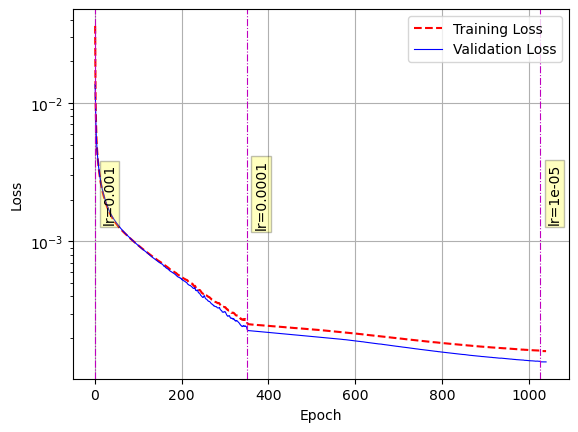

In [36]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 52


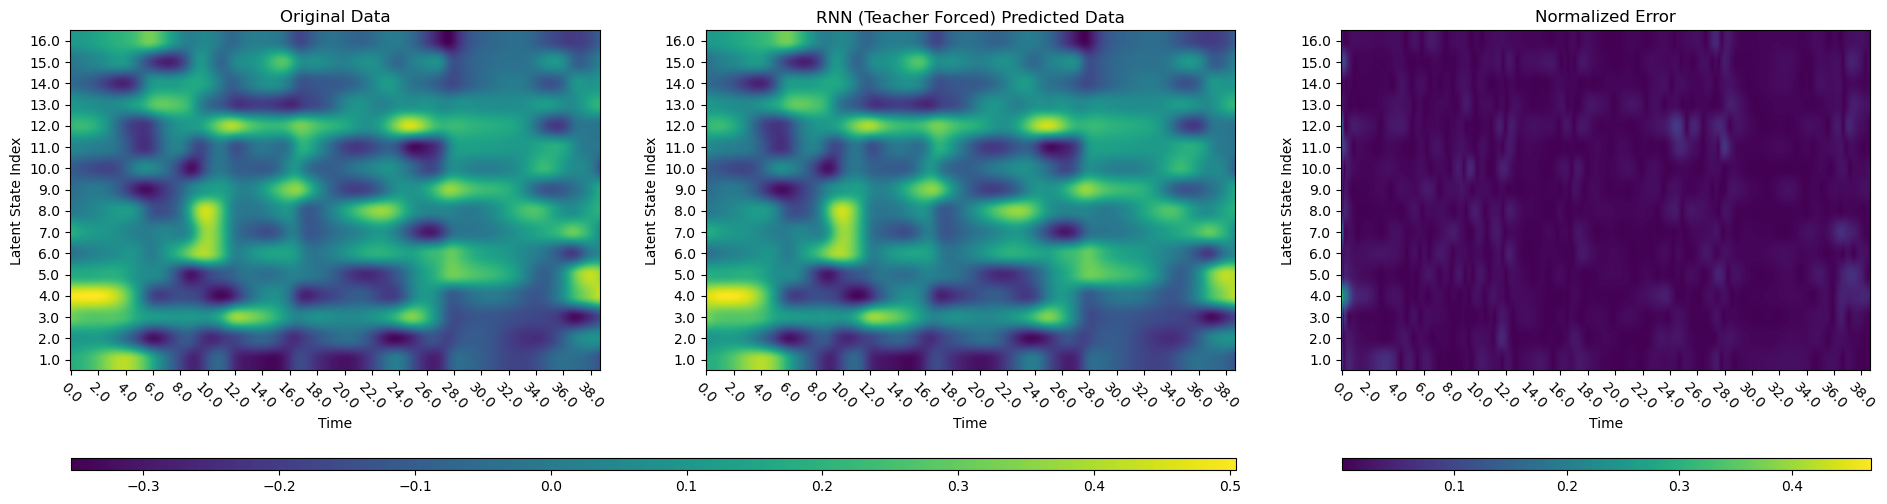

In [37]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [38]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [39]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


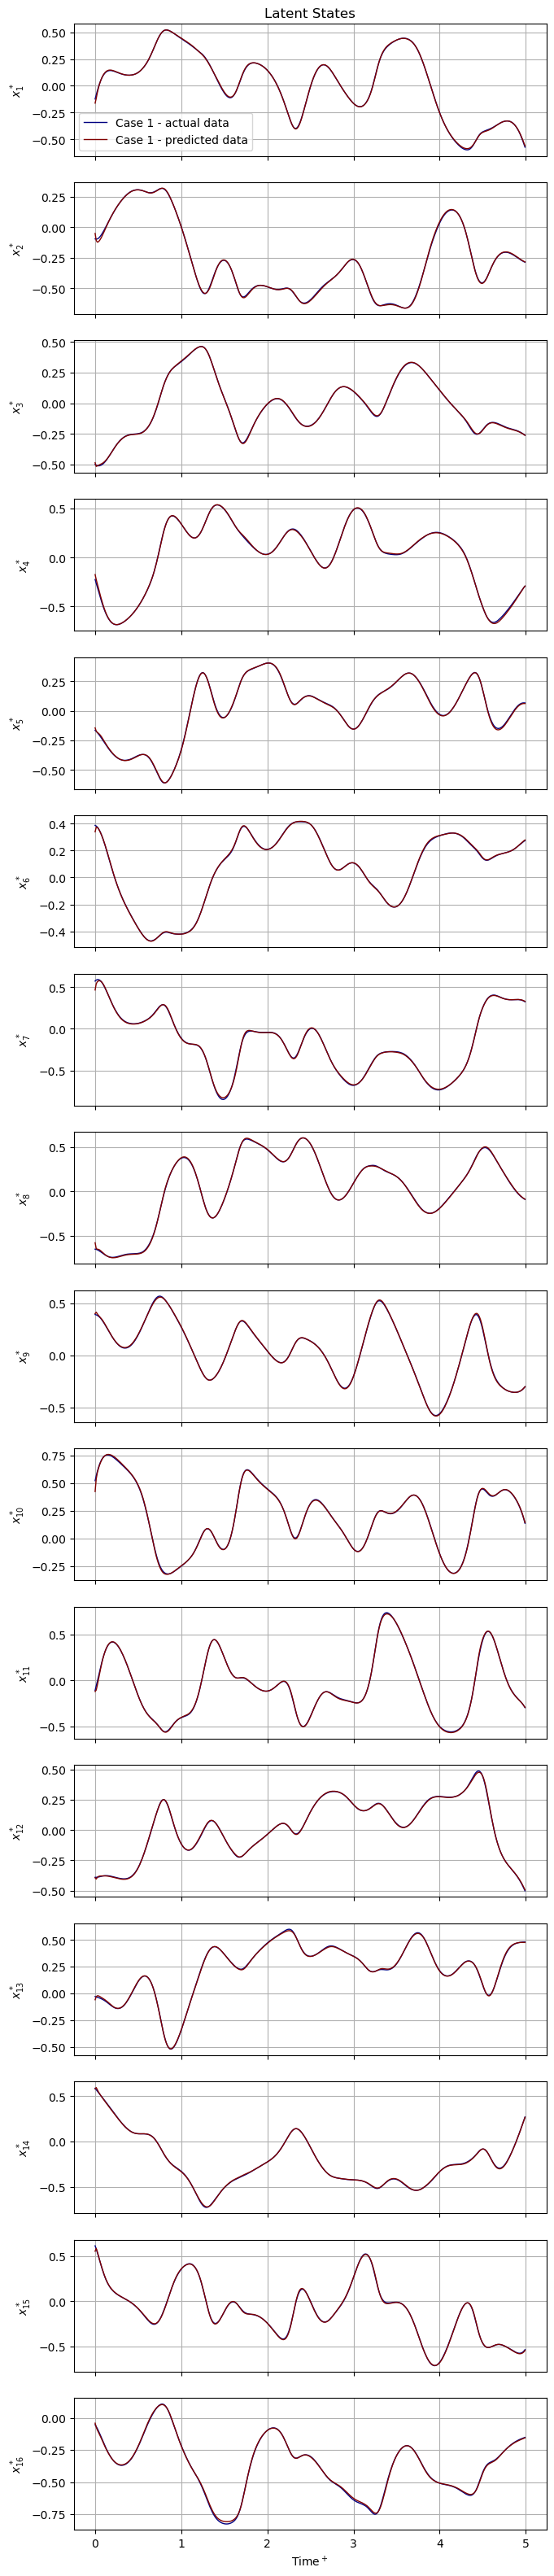


4.991497332033017


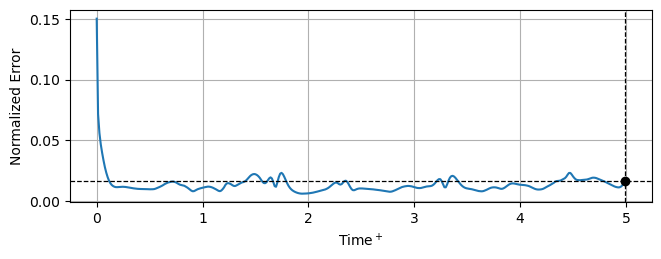

In [40]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [41]:
normalization_arr

array([[-0.01334152, -0.00261581,  0.02099581,  0.03006471,  0.0282602 ,
         0.0071317 ,  0.01005646,  0.07305361,  0.03375387,  0.02128131,
        -0.01137792, -0.0153523 ,  0.02832958,  0.00729525,  0.06112615,
         0.03638883],
       [ 0.57221735,  0.5165402 ,  0.56873006,  0.5798129 ,  0.5267395 ,
         0.5602617 ,  0.5400706 ,  0.5276647 ,  0.55953586,  0.4929259 ,
         0.45475405,  0.5388398 ,  0.49729973,  0.5216943 ,  0.44654998,
         0.49534416]], dtype=float32)

# Autoregressive Mode

In [42]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [43]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 11837
data_.shape : (1, 464, 16)


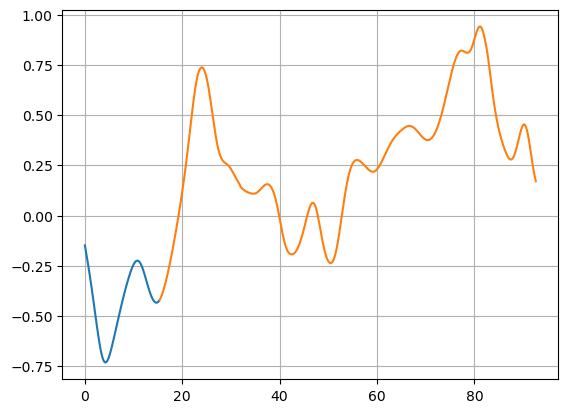

In [51]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [52]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [53]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 387, 16)


In [54]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.4655282485833902


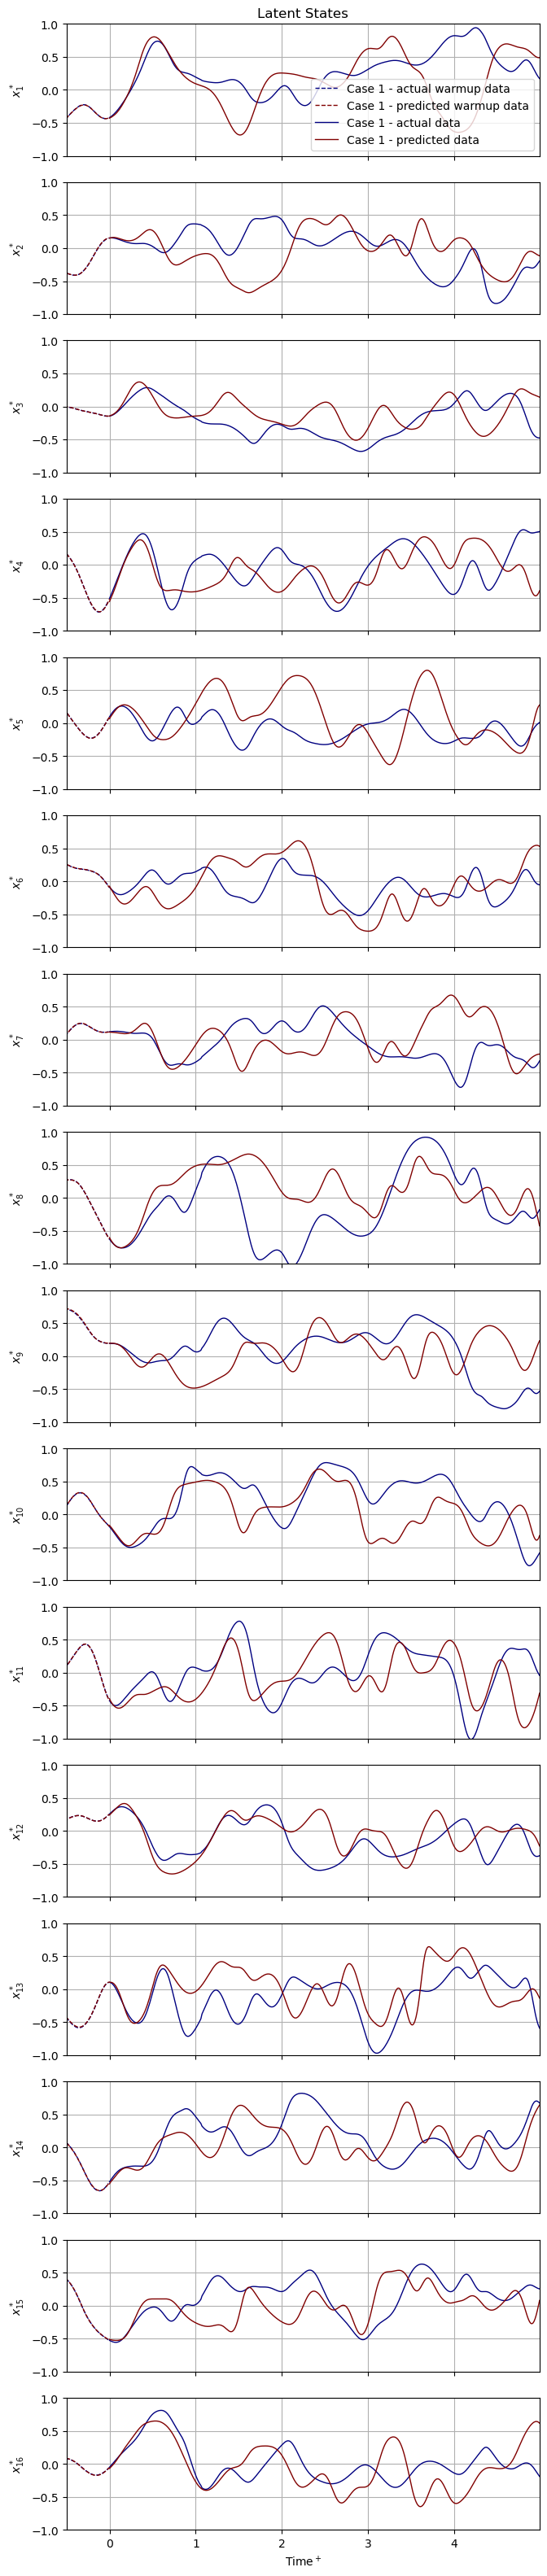

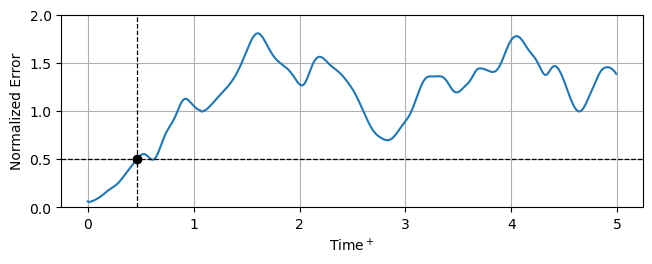

In [55]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [56]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [57]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.417086 , 1.526678 , 1.3865345, 1.2515259, 1.4284375, 1.4851857,
        1.4662651, 1.6167802, 1.4540565, 1.3977273, 1.5087386, 1.1353328,
        1.4522072, 1.16904  , 1.4590656, 1.4977577], dtype=float32)>]